In [ ]:
# default_exp funcs.merfish_codenet

In [ ]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# export
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
import torch.nn as nn
import torch.nn.functional as F
from decode_fish.funcs.predict import *

from omegaconf import open_dict
from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *

In [ ]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_22/seed:3xnorm:nonexmodel_init:nullxmean_diff:True//train.yaml')

In [ ]:
cfg.genm.foci.n_foci_avg = 0
cfg.training.bs = 20
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/cuda/__init__.py:122: UserWarning: 
    Found GPU2 NVS 510 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


Crop size larger than volume in at least one dimension. Crop size changed to (1, 56, 56)
7 volumes


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
from decode_fish.funcs.exp_specific import *
codebook, targets = get_mop_codebook()

In [ ]:
# export

# def input_from_df(df, from_matches=True):
                    
#     df_str = '_pred' if from_matches else  ''
#     df = get_code_from_ints(df, codebook, targets, int_str=df_str)
#     matched_codes = codebook[df['code_inds'].values]
    
#     input_keys = ['prob'+df_str,'x_sig'+df_str,'y_sig'+df_str, 'code_err'] + [f'int_{i}{df_str}' for i in range(16)] + [f'int_sig_{i}{df_str}' for i in range(16)]
#     inp_arr = df[input_keys].values
#     return np.concatenate([df[input_keys].values, matched_codes], 1)

# def input_from_df(df, codebook, targets, from_matches=True):
                    
#     df_str = '_pred' if from_matches else  ''
#     df = get_code_from_ints(df, codebook, targets, int_str=df_str)
#     matched_codes = codebook[df['code_inds'].values]
    
#     input_keys = ['prob'+df_str,'x_sig'+df_str,'y_sig'+df_str, 'code_err'] #+ ['rec_rmses'] + [f'int_sig_{i}{df_str}' for i in range(16)]
#     inp_arr = df[input_keys].values
#     int_sum = df[[f'int_{i}{df_str}' for i in range(16)]].values.sum(-1)[:,None]
#     ints_sum = df[[f'int_sig_{i}{df_str}' for i in range(16)]].values.sum(-1)[:,None]
    
#     return np.concatenate([inp_arr, int_sum, ints_sum], 1)

def input_from_df(df):
                    
    input_keys = ['prob','x_sig','y_sig','z_sig'] + [f'int_sig_{i}' for i in range(4)]  + [f'int_{i}' for i in range(4)]
    inp_arr = df[input_keys].values
    
    return inp_arr
#     int_sum = df[[f'int_{i}' for i in range(16)]].values.sum(-1)[:,None]
#     ints_sum = df[[f'int_sig_{i}' for i in range(16)]].values.sum(-1)[:,None]
    
#     return np.concatenate([inp_arr, int_sum, ints_sum], 1)



# def target_from_matches(matches_df, codebook, targets):
    
#     matches_df = get_code_from_ints(matches_df, codebook, targets, int_str='_pred')
#     matched_codes = codebook[matches_df['code_inds'].values]
    
# #     int_arr = matches_df[[f'int_{i}_tar' for i in range(16)]]
# #     tar_code = np.where(int_arr>0,1,0)
    
#     int_arr = matches_df[[f'int_{i}_tar' for i in range(16)]].values
#     s_arr = np.sort(int_arr)
#     lim = s_arr[:,-5]
#     tar_code = np.stack([np.where(i>l,1,0) for i,l in zip(int_arr, lim)])
#     matches_df[[f'int_{i}_tar' for i in range(16)]] = tar_code
#     matches_df = get_code_from_ints(matches_df, codebook, targets, int_str='_tar')
#     tar_code = codebook[matches_df['code_inds'].values]

#     return  1 - abs(np.array(matched_codes, dtype='int') - np.array(tar_code, dtype='int')).max(1)

def extract_rmses(vol, ixy_coords, size_xy = 10, px_size=100):

    rmses = []
    
    for k in range(len(ixy_coords)):

        i, x, y = ixy_coords[k]
        crop = np.s_[int(i),:, np.max([0,int(y/px_size-size_xy)]): int(y/px_size+size_xy+1), np.max([0,int(x/px_size-size_xy)]): int(x/px_size+size_xy+1)]
        
        rmses.append(vol[crop].mean().item())
        
    return rmses

In [ ]:
# export
class code_net(nn.Module):

    def __init__(self, n_inputs=48, n_outputs=1):
        super(code_net, self).__init__()
        
        self.layers = nn.Sequential(
          nn.Linear(n_inputs, 256),
          nn.BatchNorm1d(256),
          nn.ReLU(),
          nn.Linear(256, 128),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Linear(128, 64),
          nn.BatchNorm1d(64),
          nn.ReLU(),
          nn.Linear(64, 32),
          nn.BatchNorm1d(32),
          nn.ReLU(),
          nn.Linear(32, n_outputs)
        )
        
    def forward(self, x):
        
        return self.layers(x)

net = code_net().cuda()

def input_from_df(df, codebook):
                    
    input_keys = ['prob', 'x_sig','y_sig','z_sig'] + [f'int_sig_{i}' for i in range(22)]  + [f'int_{i}' for i in range(22)]
    offsets = [0.75, 20., 20., 15.] + 22*[1.] + 22*[0.]
    scales = [1., 20., 20., 15.] + 22*[2.] + 22*[5.]
    inp_arr = df[input_keys].values
    inp_arr = (inp_arr - np.array(offsets))/np.array(scales)
    
#     inp_arr = np.concatenate([inp_arr, codebook[df['code_inds'].values]], 1)
    inp_arr[:,-22:] = inp_arr[:,-22:] - 2*(inp_arr[:,-22:] * codebook[df['code_inds'].values])
    
    return torch.tensor(inp_arr, dtype=torch.float32).cuda()

In [ ]:
from decode_fish.engine.point_process import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.engine.gmm_loss import *
from decode_fish.engine.microscope import add_pos_noise
from sklearn.utils import resample

num_iters = 500
batch_size = 200
i = 0

bce = torch.nn.BCEWithLogitsLoss()
opt = torch.optim.AdamW(net.parameters(), lr = 5e-3)
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=100, gamma=0.5)
loss_col = []

model.eval().cuda()

for i in tqdm(range(num_iters)):

    with torch.no_grad():

        ret_dict = next(iter(decode_dl))
        x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'], 
        zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
        background = background * micro.get_ch_mult()
        local_rate *= 2

        sim_vars = PointProcessUniform(local_rate[:,0] ,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc, channels=cfg.genm.exp_type.n_channels, n_bits=4, sim_z=True, codebook=torch.tensor(codebook), int_option=cfg.training.int_option).sample(from_code_book=True)
        ch_inp = list(micro.get_single_ch_inputs(*sim_vars[:-1], ycrop=ycrop.flatten(), xcrop=xcrop.flatten()))
        ch_inp[1:4] = add_pos_noise(ch_inp[1:4], [cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_z], cfg.genm.exp_type.n_bits)
        xsim = micro(*ch_inp, add_noise=True)


        noise_vars = PointProcessUniform(local_rate[:,0] * cfg.genm.emitter_noise.rate_fac, int_conc=model.int_dist.int_conc.detach() * cfg.genm.emitter_noise.int_fac, 
                                       int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(), 
                                       sim_iters=5, channels=cfg.genm.exp_type.n_channels, n_bits=1, 
                                       sim_z=cfg.genm.exp_type.pred_z, codebook=None, int_option=cfg.training.int_option).sample(from_code_book=False)     

        noise_inp = micro.get_single_ch_inputs(*noise_vars[:-1], ycrop=ycrop.flatten(), xcrop=xcrop.flatten())
        xsim += micro(*noise_inp, add_noise=True)

        x = micro.noise(xsim, background, const_theta_sim=cfg.genm.exp_type.const_theta_sim).sample()

        colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)
        net_inp = torch.concat([x,colshift_crop], 1)
        
        gt_vars = sim_vars[:-2] 
        gt_df = sample_to_df(*gt_vars, sim_vars[-1], px_size_zyx=[1.,1.,1.])

        res_dict = model(net_inp.cuda())
        res_dict = model.tensor_to_dict(res_dict)
        pred_df = post_proc.get_df(res_dict)
        pred_df['gene'] = targets[pred_df['code_inds']]
#         pred_df = sel_int_ch(pred_df, codebook)
        
        perf, matches, _ = matching(px_to_nm(gt_df), pred_df, tolerance=500, print_res=False)
        
        pred_df.loc[:, 'class'] = 1
        pred_df.loc[pred_df['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0

    opt.zero_grad()

    ''''''
    df_majority = pred_df[pred_df['class']==0]
    df_minority = pred_df[pred_df['class']==1]

    df_maj_down = resample(df_majority, replace=True, n_samples=len(df_minority)*2)

    pred_df = pd.concat([df_minority, df_maj_down])    
    ''''''
    
    net_inp = input_from_df(pred_df, codebook)
    net_out = net(net_inp)

    net_tar = torch.tensor(pred_df['class'].values, dtype=torch.float32).cuda()
    loss = bce(net_out, net_tar[:,None])
    print(loss.item())

    loss.backward()

    opt.step()
    sched.step()

    loss_col.append(loss.item())

  0%|▎                                                                                                                                                   | 1/500 [00:02<20:13,  2.43s/it]

0.7822973132133484


  0%|▌                                                                                                                                                   | 2/500 [00:04<20:35,  2.48s/it]

0.7024686336517334


  1%|▉                                                                                                                                                   | 3/500 [00:07<20:14,  2.44s/it]

0.706357479095459


  1%|█▏                                                                                                                                                  | 4/500 [00:09<19:12,  2.32s/it]

0.6818204522132874


  1%|█▍                                                                                                                                                  | 5/500 [00:11<18:40,  2.26s/it]

0.6657113432884216


  1%|█▊                                                                                                                                                  | 6/500 [00:14<19:57,  2.42s/it]

0.6418067216873169


  1%|██                                                                                                                                                  | 7/500 [00:16<19:18,  2.35s/it]

0.5727661848068237


  2%|██▎                                                                                                                                                 | 8/500 [00:18<18:44,  2.29s/it]

0.5768635272979736


  2%|██▋                                                                                                                                                 | 9/500 [00:20<17:48,  2.18s/it]

0.5674391984939575


  2%|██▉                                                                                                                                                | 10/500 [00:23<18:38,  2.28s/it]

0.5989927649497986


  2%|███▏                                                                                                                                               | 11/500 [00:25<18:34,  2.28s/it]

0.5645403265953064


  2%|███▌                                                                                                                                               | 12/500 [00:27<17:58,  2.21s/it]

0.5291199684143066


  3%|███▊                                                                                                                                               | 13/500 [00:29<18:02,  2.22s/it]

0.5707996487617493


  3%|████                                                                                                                                               | 14/500 [00:32<18:27,  2.28s/it]

0.5665977001190186


  3%|████▍                                                                                                                                              | 15/500 [00:33<17:13,  2.13s/it]

0.5404040813446045


  3%|████▋                                                                                                                                              | 16/500 [00:35<16:32,  2.05s/it]

0.5351479053497314


  3%|████▉                                                                                                                                              | 17/500 [00:37<16:45,  2.08s/it]

0.5508768558502197


  4%|█████▎                                                                                                                                             | 18/500 [00:40<17:58,  2.24s/it]

0.5835928320884705


  4%|█████▌                                                                                                                                             | 19/500 [00:42<17:48,  2.22s/it]

0.5314304828643799


  4%|█████▉                                                                                                                                             | 20/500 [00:45<18:53,  2.36s/it]

0.5308269262313843


  4%|██████▏                                                                                                                                            | 21/500 [00:47<18:17,  2.29s/it]

0.5706958770751953


  4%|██████▍                                                                                                                                            | 22/500 [00:49<17:52,  2.24s/it]

0.5885717272758484


  5%|██████▊                                                                                                                                            | 23/500 [00:51<17:20,  2.18s/it]

0.5641858577728271


  5%|███████                                                                                                                                            | 24/500 [00:54<18:17,  2.31s/it]

0.5356655716896057


  5%|███████▎                                                                                                                                           | 25/500 [00:56<17:54,  2.26s/it]

0.5643291473388672


  5%|███████▋                                                                                                                                           | 26/500 [00:58<18:06,  2.29s/it]

0.5306703448295593


  5%|███████▉                                                                                                                                           | 27/500 [01:01<18:59,  2.41s/it]

0.5207989811897278


  6%|████████▏                                                                                                                                          | 28/500 [01:04<19:05,  2.43s/it]

0.5492571592330933


  6%|████████▌                                                                                                                                          | 29/500 [01:06<18:23,  2.34s/it]

0.5409415364265442


  6%|████████▊                                                                                                                                          | 30/500 [01:08<17:53,  2.28s/it]

0.557273805141449


  6%|█████████                                                                                                                                          | 31/500 [01:10<18:25,  2.36s/it]

0.5510551929473877


  6%|█████████▍                                                                                                                                         | 32/500 [01:13<18:16,  2.34s/it]

0.5478802919387817


  7%|█████████▋                                                                                                                                         | 33/500 [01:15<17:53,  2.30s/it]

0.5252451300621033


  7%|█████████▉                                                                                                                                         | 34/500 [01:17<18:19,  2.36s/it]

0.5591447353363037


  7%|██████████▎                                                                                                                                        | 35/500 [01:19<17:33,  2.26s/it]

0.5744403600692749


  7%|██████████▌                                                                                                                                        | 36/500 [01:21<16:57,  2.19s/it]

0.5730740427970886


  7%|██████████▉                                                                                                                                        | 37/500 [01:23<16:28,  2.13s/it]

0.5034378170967102


  8%|███████████▏                                                                                                                                       | 38/500 [01:26<17:27,  2.27s/it]

0.5308132767677307


  8%|███████████▍                                                                                                                                       | 39/500 [01:28<16:38,  2.17s/it]

0.5207554697990417


  8%|███████████▊                                                                                                                                       | 40/500 [01:30<15:32,  2.03s/it]

0.5294983386993408


  8%|████████████                                                                                                                                       | 41/500 [01:32<15:18,  2.00s/it]

0.5401912927627563


  8%|████████████▎                                                                                                                                      | 42/500 [01:34<15:36,  2.05s/it]

0.5360066294670105


  9%|████████████▋                                                                                                                                      | 43/500 [01:36<15:49,  2.08s/it]

0.5511422753334045


  9%|████████████▉                                                                                                                                      | 44/500 [01:38<15:43,  2.07s/it]

0.5310352444648743


  9%|█████████████▏                                                                                                                                     | 45/500 [01:40<15:30,  2.05s/it]

0.552075982093811


  9%|█████████████▌                                                                                                                                     | 46/500 [01:42<16:03,  2.12s/it]

0.5091024041175842


  9%|█████████████▊                                                                                                                                     | 47/500 [01:44<15:43,  2.08s/it]

0.5393956899642944


 10%|██████████████                                                                                                                                     | 48/500 [01:46<15:54,  2.11s/it]

0.5286480784416199


 10%|██████████████▍                                                                                                                                    | 49/500 [01:49<18:01,  2.40s/it]

0.5488584041595459


 10%|██████████████▋                                                                                                                                    | 50/500 [01:51<17:09,  2.29s/it]

0.5496541261672974


 10%|██████████████▉                                                                                                                                    | 51/500 [01:54<16:46,  2.24s/it]

0.5410534739494324


 10%|███████████████▎                                                                                                                                   | 52/500 [01:55<15:32,  2.08s/it]

0.510291337966919


 11%|███████████████▌                                                                                                                                   | 53/500 [01:57<15:29,  2.08s/it]

0.5328497886657715


 11%|███████████████▉                                                                                                                                   | 54/500 [01:59<15:25,  2.07s/it]

0.5525319576263428


 11%|████████████████▏                                                                                                                                  | 55/500 [02:01<14:44,  1.99s/it]

0.5700440406799316


 11%|████████████████▍                                                                                                                                  | 56/500 [02:04<16:13,  2.19s/it]

0.53396075963974


 11%|████████████████▊                                                                                                                                  | 57/500 [02:06<16:32,  2.24s/it]

0.5400863289833069


 12%|█████████████████                                                                                                                                  | 58/500 [02:08<16:16,  2.21s/it]

0.5596673488616943


 12%|█████████████████▎                                                                                                                                 | 59/500 [02:11<17:20,  2.36s/it]

0.5419942736625671


 12%|█████████████████▋                                                                                                                                 | 60/500 [02:13<16:48,  2.29s/it]

0.5436607599258423


 12%|█████████████████▉                                                                                                                                 | 61/500 [02:15<16:22,  2.24s/it]

0.5870247483253479


 12%|██████████████████▏                                                                                                                                | 62/500 [02:18<16:12,  2.22s/it]

0.5624497532844543


 13%|██████████████████▌                                                                                                                                | 63/500 [02:21<17:53,  2.46s/it]

0.5247337818145752


 13%|██████████████████▊                                                                                                                                | 64/500 [02:23<17:19,  2.38s/it]

0.5323139429092407


 13%|███████████████████                                                                                                                                | 65/500 [02:24<15:45,  2.17s/it]

0.5588682889938354


 13%|███████████████████▍                                                                                                                               | 66/500 [02:26<14:33,  2.01s/it]

0.5294352769851685


 13%|███████████████████▋                                                                                                                               | 67/500 [02:28<14:14,  1.97s/it]

0.5123962163925171


 14%|███████████████████▉                                                                                                                               | 68/500 [02:30<13:53,  1.93s/it]

0.5225911736488342


 14%|████████████████████▎                                                                                                                              | 69/500 [02:31<13:11,  1.84s/it]

0.5359767079353333


 14%|████████████████████▌                                                                                                                              | 70/500 [02:33<12:26,  1.74s/it]

0.5176596641540527


 14%|████████████████████▊                                                                                                                              | 71/500 [02:35<13:24,  1.87s/it]

0.5301916003227234


 14%|█████████████████████▏                                                                                                                             | 72/500 [02:37<14:23,  2.02s/it]

0.5619508624076843


 15%|█████████████████████▍                                                                                                                             | 73/500 [02:39<14:17,  2.01s/it]

0.5354151129722595


 15%|█████████████████████▊                                                                                                                             | 74/500 [02:42<15:48,  2.23s/it]

0.5734996199607849


 15%|██████████████████████                                                                                                                             | 75/500 [02:45<16:01,  2.26s/it]

0.5188639760017395


 15%|██████████████████████▎                                                                                                                            | 76/500 [02:47<16:07,  2.28s/it]

0.5050300359725952


 15%|██████████████████████▋                                                                                                                            | 77/500 [02:49<15:21,  2.18s/it]

0.517471969127655


 16%|██████████████████████▉                                                                                                                            | 78/500 [02:51<15:24,  2.19s/it]

0.5487527251243591


 16%|███████████████████████▏                                                                                                                           | 79/500 [02:53<14:19,  2.04s/it]

0.4788253903388977


 16%|███████████████████████▌                                                                                                                           | 80/500 [02:55<14:55,  2.13s/it]

0.5548767447471619


 16%|███████████████████████▊                                                                                                                           | 81/500 [02:57<14:35,  2.09s/it]

0.5410197973251343


 16%|████████████████████████                                                                                                                           | 82/500 [02:59<14:53,  2.14s/it]

0.5799286961555481


 17%|████████████████████████▍                                                                                                                          | 83/500 [03:02<15:24,  2.22s/it]

0.5743035078048706


 17%|████████████████████████▋                                                                                                                          | 84/500 [03:04<14:41,  2.12s/it]

0.5288669466972351


 17%|████████████████████████▉                                                                                                                          | 85/500 [03:06<15:19,  2.22s/it]

0.5635272860527039


 17%|█████████████████████████▎                                                                                                                         | 86/500 [03:08<15:01,  2.18s/it]

0.5286573171615601


 17%|█████████████████████████▌                                                                                                                         | 87/500 [03:10<14:42,  2.14s/it]

0.5188764929771423


 18%|█████████████████████████▊                                                                                                                         | 88/500 [03:12<14:22,  2.09s/it]

0.5247611999511719


 18%|██████████████████████████▏                                                                                                                        | 89/500 [03:14<14:40,  2.14s/it]

0.5643247961997986


 18%|██████████████████████████▍                                                                                                                        | 90/500 [03:16<14:13,  2.08s/it]

0.5526036620140076


 18%|██████████████████████████▊                                                                                                                        | 91/500 [03:19<15:27,  2.27s/it]

0.5699812769889832


 18%|███████████████████████████                                                                                                                        | 92/500 [03:21<14:47,  2.18s/it]

0.5488120913505554


 19%|███████████████████████████▎                                                                                                                       | 93/500 [03:24<15:28,  2.28s/it]

0.5613399744033813


 19%|███████████████████████████▋                                                                                                                       | 94/500 [03:25<14:35,  2.16s/it]

0.5413474440574646


 19%|███████████████████████████▉                                                                                                                       | 95/500 [03:27<13:58,  2.07s/it]

0.5348175168037415


 19%|████████████████████████████▏                                                                                                                      | 96/500 [03:30<14:23,  2.14s/it]

0.5089296698570251


 19%|████████████████████████████▌                                                                                                                      | 97/500 [03:32<15:46,  2.35s/it]

0.5249089598655701


 20%|████████████████████████████▊                                                                                                                      | 98/500 [03:35<15:57,  2.38s/it]

0.5224952101707458


 20%|█████████████████████████████                                                                                                                      | 99/500 [03:37<15:01,  2.25s/it]

0.5273554921150208


 20%|█████████████████████████████▏                                                                                                                    | 100/500 [03:40<16:06,  2.42s/it]

0.5385203957557678


 20%|█████████████████████████████▍                                                                                                                    | 101/500 [03:42<15:55,  2.40s/it]

0.5782687067985535


 20%|█████████████████████████████▊                                                                                                                    | 102/500 [03:44<15:25,  2.33s/it]

0.5481764674186707


 21%|██████████████████████████████                                                                                                                    | 103/500 [03:47<15:56,  2.41s/it]

0.548545241355896


 21%|██████████████████████████████▎                                                                                                                   | 104/500 [03:49<15:36,  2.36s/it]

0.5476717948913574


 21%|██████████████████████████████▋                                                                                                                   | 105/500 [03:51<14:35,  2.22s/it]

0.5312024354934692


 21%|██████████████████████████████▉                                                                                                                   | 106/500 [03:53<14:54,  2.27s/it]

0.5530503988265991


 21%|███████████████████████████████▏                                                                                                                  | 107/500 [03:56<15:59,  2.44s/it]

0.5676714777946472


 22%|███████████████████████████████▌                                                                                                                  | 108/500 [03:58<14:44,  2.26s/it]

0.5273630023002625


 22%|███████████████████████████████▊                                                                                                                  | 109/500 [04:00<14:27,  2.22s/it]

0.5134390592575073


 22%|████████████████████████████████                                                                                                                  | 110/500 [04:02<13:47,  2.12s/it]

0.5127967596054077


 22%|████████████████████████████████▍                                                                                                                 | 111/500 [04:04<14:32,  2.24s/it]

0.5760005116462708


 22%|████████████████████████████████▋                                                                                                                 | 112/500 [04:06<13:59,  2.16s/it]

0.5154075622558594


 23%|████████████████████████████████▉                                                                                                                 | 113/500 [04:09<13:49,  2.14s/it]

0.5257061719894409


 23%|█████████████████████████████████▎                                                                                                                | 114/500 [04:11<13:35,  2.11s/it]

0.5262852311134338


 23%|█████████████████████████████████▌                                                                                                                | 115/500 [04:13<14:07,  2.20s/it]

0.5365801453590393


 23%|█████████████████████████████████▊                                                                                                                | 116/500 [04:15<14:25,  2.25s/it]

0.5590555667877197


 23%|██████████████████████████████████▏                                                                                                               | 117/500 [04:18<14:21,  2.25s/it]

0.549812912940979


 24%|██████████████████████████████████▍                                                                                                               | 118/500 [04:20<14:56,  2.35s/it]

0.5300866365432739


 24%|██████████████████████████████████▋                                                                                                               | 119/500 [04:22<14:39,  2.31s/it]

0.535666286945343


 24%|███████████████████████████████████                                                                                                               | 120/500 [04:24<14:15,  2.25s/it]

0.538291871547699


 24%|███████████████████████████████████▎                                                                                                              | 121/500 [04:26<13:19,  2.11s/it]

0.5197978615760803


 24%|███████████████████████████████████▌                                                                                                              | 122/500 [04:29<13:59,  2.22s/it]

0.528126060962677


 25%|███████████████████████████████████▉                                                                                                              | 123/500 [04:31<14:16,  2.27s/it]

0.5436599850654602


 25%|████████████████████████████████████▏                                                                                                             | 124/500 [04:33<13:37,  2.17s/it]

0.5150163173675537


 25%|████████████████████████████████████▌                                                                                                             | 125/500 [04:35<13:29,  2.16s/it]

0.5673916339874268


 25%|████████████████████████████████████▊                                                                                                             | 126/500 [04:38<14:52,  2.39s/it]

0.5556036233901978


 25%|█████████████████████████████████████                                                                                                             | 127/500 [04:40<14:01,  2.26s/it]

0.5321809649467468


 26%|█████████████████████████████████████▍                                                                                                            | 128/500 [04:42<13:16,  2.14s/it]

0.52408766746521


 26%|█████████████████████████████████████▋                                                                                                            | 129/500 [04:44<12:32,  2.03s/it]

0.545319139957428


 26%|█████████████████████████████████████▉                                                                                                            | 130/500 [04:46<12:25,  2.02s/it]

0.5628206729888916


 26%|██████████████████████████████████████▎                                                                                                           | 131/500 [04:48<13:08,  2.14s/it]

0.5508695840835571


 26%|██████████████████████████████████████▌                                                                                                           | 132/500 [04:50<13:17,  2.17s/it]

0.518548846244812


 27%|██████████████████████████████████████▊                                                                                                           | 133/500 [04:53<13:55,  2.28s/it]

0.5501508712768555


 27%|███████████████████████████████████████▏                                                                                                          | 134/500 [04:55<13:22,  2.19s/it]

0.53224778175354


 27%|███████████████████████████████████████▍                                                                                                          | 135/500 [04:57<13:08,  2.16s/it]

0.5380979776382446


 27%|███████████████████████████████████████▋                                                                                                          | 136/500 [04:59<11:58,  1.97s/it]

0.5160759687423706


 27%|████████████████████████████████████████                                                                                                          | 137/500 [05:01<12:20,  2.04s/it]

0.5378740429878235


 28%|████████████████████████████████████████▎                                                                                                         | 138/500 [05:03<12:22,  2.05s/it]

0.5360367894172668


 28%|████████████████████████████████████████▌                                                                                                         | 139/500 [05:05<12:36,  2.09s/it]

0.5247906446456909


 28%|████████████████████████████████████████▉                                                                                                         | 140/500 [05:07<12:32,  2.09s/it]

0.5538802742958069


 28%|█████████████████████████████████████████▏                                                                                                        | 141/500 [05:10<13:33,  2.27s/it]

0.5496810674667358


 28%|█████████████████████████████████████████▍                                                                                                        | 142/500 [05:12<13:46,  2.31s/it]

0.5220781564712524


 29%|█████████████████████████████████████████▊                                                                                                        | 143/500 [05:14<13:10,  2.21s/it]

0.5661802887916565


 29%|██████████████████████████████████████████                                                                                                        | 144/500 [05:17<13:29,  2.27s/it]

0.5135079622268677


 29%|██████████████████████████████████████████▎                                                                                                       | 145/500 [05:19<13:11,  2.23s/it]

0.536910355091095


 29%|██████████████████████████████████████████▋                                                                                                       | 146/500 [05:21<13:19,  2.26s/it]

0.5495710968971252


 29%|██████████████████████████████████████████▉                                                                                                       | 147/500 [05:23<13:24,  2.28s/it]

0.5467517375946045


 30%|███████████████████████████████████████████▏                                                                                                      | 148/500 [05:26<13:25,  2.29s/it]

0.5040172338485718


 30%|███████████████████████████████████████████▌                                                                                                      | 149/500 [05:28<12:46,  2.18s/it]

0.5225932598114014


 30%|███████████████████████████████████████████▊                                                                                                      | 150/500 [05:30<12:34,  2.16s/it]

0.5595331192016602


 30%|████████████████████████████████████████████                                                                                                      | 151/500 [05:32<12:07,  2.08s/it]

0.5372328162193298


 30%|████████████████████████████████████████████▍                                                                                                     | 152/500 [05:34<12:57,  2.23s/it]

0.5085210800170898


 31%|████████████████████████████████████████████▋                                                                                                     | 153/500 [05:36<12:45,  2.20s/it]

0.5202062726020813


 31%|████████████████████████████████████████████▉                                                                                                     | 154/500 [05:39<12:56,  2.24s/it]

0.5285131931304932


 31%|█████████████████████████████████████████████▎                                                                                                    | 155/500 [05:41<13:13,  2.30s/it]

0.51212477684021


 31%|█████████████████████████████████████████████▌                                                                                                    | 156/500 [05:44<13:31,  2.36s/it]

0.5452967286109924


 31%|█████████████████████████████████████████████▊                                                                                                    | 157/500 [05:46<12:45,  2.23s/it]

0.509949803352356


 32%|██████████████████████████████████████████████▏                                                                                                   | 158/500 [05:48<13:42,  2.40s/it]

0.5747168064117432


 32%|██████████████████████████████████████████████▍                                                                                                   | 159/500 [05:51<13:25,  2.36s/it]

0.5526672005653381


 32%|██████████████████████████████████████████████▋                                                                                                   | 160/500 [05:53<12:51,  2.27s/it]

0.5272054672241211


 32%|███████████████████████████████████████████████                                                                                                   | 161/500 [05:55<12:39,  2.24s/it]

0.5123589634895325


 32%|███████████████████████████████████████████████▎                                                                                                  | 162/500 [05:58<13:26,  2.39s/it]

0.5006441473960876


 33%|███████████████████████████████████████████████▌                                                                                                  | 163/500 [06:00<12:42,  2.26s/it]

0.520317792892456


 33%|███████████████████████████████████████████████▉                                                                                                  | 164/500 [06:01<12:11,  2.18s/it]

0.5571892261505127


 33%|████████████████████████████████████████████████▏                                                                                                 | 165/500 [06:04<13:07,  2.35s/it]

0.5474880933761597


 33%|████████████████████████████████████████████████▍                                                                                                 | 166/500 [06:06<12:32,  2.25s/it]

0.5171483159065247


 33%|████████████████████████████████████████████████▊                                                                                                 | 167/500 [06:08<12:06,  2.18s/it]

0.5362970232963562


 34%|█████████████████████████████████████████████████                                                                                                 | 168/500 [06:10<11:36,  2.10s/it]

0.5057423710823059


 34%|█████████████████████████████████████████████████▎                                                                                                | 169/500 [06:13<12:39,  2.30s/it]

0.5182152390480042


 34%|█████████████████████████████████████████████████▋                                                                                                | 170/500 [06:15<12:30,  2.27s/it]

0.5122573375701904


 34%|█████████████████████████████████████████████████▉                                                                                                | 171/500 [06:17<12:07,  2.21s/it]

0.5408653616905212


 34%|██████████████████████████████████████████████████▏                                                                                               | 172/500 [06:20<12:23,  2.27s/it]

0.5427913665771484


 35%|██████████████████████████████████████████████████▌                                                                                               | 173/500 [06:22<12:14,  2.25s/it]

0.5190127491950989


 35%|██████████████████████████████████████████████████▊                                                                                               | 174/500 [06:24<11:49,  2.18s/it]

0.5321781039237976


 35%|███████████████████████████████████████████████████                                                                                               | 175/500 [06:26<12:08,  2.24s/it]

0.5430919528007507


 35%|███████████████████████████████████████████████████▍                                                                                              | 176/500 [06:29<12:42,  2.35s/it]

0.5433521270751953


 35%|███████████████████████████████████████████████████▋                                                                                              | 177/500 [06:31<12:01,  2.23s/it]

0.539230227470398


 36%|███████████████████████████████████████████████████▉                                                                                              | 178/500 [06:33<11:21,  2.12s/it]

0.5418133735656738


 36%|████████████████████████████████████████████████████▎                                                                                             | 179/500 [06:35<11:23,  2.13s/it]

0.5126500129699707


 36%|████████████████████████████████████████████████████▌                                                                                             | 180/500 [06:37<11:55,  2.23s/it]

0.5076116919517517


 36%|████████████████████████████████████████████████████▊                                                                                             | 181/500 [06:39<11:38,  2.19s/it]

0.5485700368881226


 36%|█████████████████████████████████████████████████████▏                                                                                            | 182/500 [06:42<11:55,  2.25s/it]

0.5398848056793213


 37%|█████████████████████████████████████████████████████▍                                                                                            | 183/500 [06:44<12:13,  2.32s/it]

0.5284826159477234


 37%|█████████████████████████████████████████████████████▋                                                                                            | 184/500 [06:47<12:09,  2.31s/it]

0.5734156966209412


 37%|██████████████████████████████████████████████████████                                                                                            | 185/500 [06:49<12:01,  2.29s/it]

0.5304329991340637


 37%|██████████████████████████████████████████████████████▎                                                                                           | 186/500 [06:51<11:47,  2.25s/it]

0.5237986445426941


 37%|██████████████████████████████████████████████████████▌                                                                                           | 187/500 [06:54<12:15,  2.35s/it]

0.5358780026435852


 38%|██████████████████████████████████████████████████████▉                                                                                           | 188/500 [06:55<10:48,  2.08s/it]

0.5217348337173462


 38%|███████████████████████████████████████████████████████▏                                                                                          | 189/500 [06:57<10:04,  1.95s/it]

0.5676495432853699


 38%|███████████████████████████████████████████████████████▍                                                                                          | 190/500 [06:58<09:48,  1.90s/it]

0.5433372855186462


 38%|███████████████████████████████████████████████████████▊                                                                                          | 191/500 [07:00<10:01,  1.95s/it]

0.520566463470459


 38%|████████████████████████████████████████████████████████                                                                                          | 192/500 [07:02<09:55,  1.93s/it]

0.5228511691093445


 39%|████████████████████████████████████████████████████████▎                                                                                         | 193/500 [07:04<09:14,  1.81s/it]

0.5430776476860046


 39%|████████████████████████████████████████████████████████▋                                                                                         | 194/500 [07:06<10:22,  2.04s/it]

0.5408013463020325


 39%|████████████████████████████████████████████████████████▉                                                                                         | 195/500 [07:09<10:27,  2.06s/it]

0.5318090915679932


 39%|█████████████████████████████████████████████████████████▏                                                                                        | 196/500 [07:11<10:35,  2.09s/it]

0.566266655921936


 39%|█████████████████████████████████████████████████████████▌                                                                                        | 197/500 [07:13<10:19,  2.04s/it]

0.5325459241867065


 40%|█████████████████████████████████████████████████████████▊                                                                                        | 198/500 [07:15<11:03,  2.20s/it]

0.5362424850463867


 40%|██████████████████████████████████████████████████████████                                                                                        | 199/500 [07:17<11:09,  2.23s/it]

0.558366060256958


 40%|██████████████████████████████████████████████████████████▍                                                                                       | 200/500 [07:19<10:45,  2.15s/it]

0.5528440475463867


 40%|██████████████████████████████████████████████████████████▋                                                                                       | 201/500 [07:21<10:23,  2.08s/it]

0.5304691195487976


 40%|██████████████████████████████████████████████████████████▉                                                                                       | 202/500 [07:23<09:52,  1.99s/it]

0.5352387428283691


 41%|███████████████████████████████████████████████████████████▎                                                                                      | 203/500 [07:25<10:01,  2.03s/it]

0.5135692954063416


 41%|███████████████████████████████████████████████████████████▌                                                                                      | 204/500 [07:28<10:22,  2.10s/it]

0.545642077922821


 41%|███████████████████████████████████████████████████████████▊                                                                                      | 205/500 [07:30<11:06,  2.26s/it]

0.5339594483375549


 41%|████████████████████████████████████████████████████████████▏                                                                                     | 206/500 [07:32<10:26,  2.13s/it]

0.5327140688896179


 41%|████████████████████████████████████████████████████████████▍                                                                                     | 207/500 [07:34<10:23,  2.13s/it]

0.5278857946395874


 42%|████████████████████████████████████████████████████████████▋                                                                                     | 208/500 [07:36<09:37,  1.98s/it]

0.5133293867111206


 42%|█████████████████████████████████████████████████████████████                                                                                     | 209/500 [07:38<10:19,  2.13s/it]

0.5499738454818726


 42%|█████████████████████████████████████████████████████████████▎                                                                                    | 210/500 [07:40<10:17,  2.13s/it]

0.5423215627670288


 42%|█████████████████████████████████████████████████████████████▌                                                                                    | 211/500 [07:43<10:33,  2.19s/it]

0.5327268242835999


 42%|█████████████████████████████████████████████████████████████▉                                                                                    | 212/500 [07:45<10:30,  2.19s/it]

0.5611581802368164


 43%|██████████████████████████████████████████████████████████████▏                                                                                   | 213/500 [07:48<11:21,  2.38s/it]

0.5496599078178406


 43%|██████████████████████████████████████████████████████████████▍                                                                                   | 214/500 [07:50<11:31,  2.42s/it]

0.5465808510780334


 43%|██████████████████████████████████████████████████████████████▊                                                                                   | 215/500 [07:52<10:27,  2.20s/it]

0.5424896478652954


 43%|███████████████████████████████████████████████████████████████                                                                                   | 216/500 [07:54<10:23,  2.20s/it]

0.5144795179367065


 43%|███████████████████████████████████████████████████████████████▎                                                                                  | 217/500 [07:56<10:14,  2.17s/it]

0.5739760398864746


 44%|███████████████████████████████████████████████████████████████▋                                                                                  | 218/500 [07:59<10:34,  2.25s/it]

0.5244285464286804


 44%|███████████████████████████████████████████████████████████████▉                                                                                  | 219/500 [08:01<10:23,  2.22s/it]

0.5358361601829529


 44%|████████████████████████████████████████████████████████████████▏                                                                                 | 220/500 [08:04<11:38,  2.49s/it]

0.538905143737793


 44%|████████████████████████████████████████████████████████████████▌                                                                                 | 221/500 [08:06<11:22,  2.45s/it]

0.5164532661437988


 44%|████████████████████████████████████████████████████████████████▊                                                                                 | 222/500 [08:08<11:01,  2.38s/it]

0.550908088684082


 45%|█████████████████████████████████████████████████████████████████                                                                                 | 223/500 [08:11<11:07,  2.41s/it]

0.5315093994140625


 45%|█████████████████████████████████████████████████████████████████▍                                                                                | 224/500 [08:13<10:36,  2.30s/it]

0.5519910454750061


 45%|█████████████████████████████████████████████████████████████████▋                                                                                | 225/500 [08:15<10:19,  2.25s/it]

0.5127415657043457


 45%|█████████████████████████████████████████████████████████████████▉                                                                                | 226/500 [08:18<10:55,  2.39s/it]

0.5056820511817932


 45%|██████████████████████████████████████████████████████████████████▎                                                                               | 227/500 [08:20<10:41,  2.35s/it]

0.49068060517311096


 46%|██████████████████████████████████████████████████████████████████▌                                                                               | 228/500 [08:22<10:07,  2.23s/it]

0.5463070273399353


 46%|██████████████████████████████████████████████████████████████████▊                                                                               | 229/500 [08:24<09:47,  2.17s/it]

0.5402860641479492


 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 230/500 [08:27<10:24,  2.31s/it]

0.5437820553779602


 46%|███████████████████████████████████████████████████████████████████▍                                                                              | 231/500 [08:29<10:41,  2.39s/it]

0.5482667684555054


 46%|███████████████████████████████████████████████████████████████████▋                                                                              | 232/500 [08:32<10:45,  2.41s/it]

0.5362371802330017


 47%|████████████████████████████████████████████████████████████████████                                                                              | 233/500 [08:34<10:38,  2.39s/it]

0.5169448852539062


 47%|████████████████████████████████████████████████████████████████████▎                                                                             | 234/500 [08:36<09:59,  2.25s/it]

0.5172646641731262


 47%|████████████████████████████████████████████████████████████████████▌                                                                             | 235/500 [08:38<09:14,  2.09s/it]

0.5408475399017334


 47%|████████████████████████████████████████████████████████████████████▉                                                                             | 236/500 [08:40<09:33,  2.17s/it]

0.5454392433166504


 47%|█████████████████████████████████████████████████████████████████████▏                                                                            | 237/500 [08:43<10:00,  2.29s/it]

0.5233936309814453


 48%|█████████████████████████████████████████████████████████████████████▍                                                                            | 238/500 [08:45<09:31,  2.18s/it]

0.5767623782157898


 48%|█████████████████████████████████████████████████████████████████████▊                                                                            | 239/500 [08:47<09:19,  2.14s/it]

0.5314357876777649


 48%|██████████████████████████████████████████████████████████████████████                                                                            | 240/500 [08:49<08:56,  2.06s/it]

0.5305150747299194


 48%|██████████████████████████████████████████████████████████████████████▎                                                                           | 241/500 [08:51<09:56,  2.30s/it]

0.5242303609848022


 48%|██████████████████████████████████████████████████████████████████████▋                                                                           | 242/500 [08:53<09:22,  2.18s/it]

0.5117694735527039


 49%|██████████████████████████████████████████████████████████████████████▉                                                                           | 243/500 [08:55<09:20,  2.18s/it]

0.5450555682182312


 49%|███████████████████████████████████████████████████████████████████████▏                                                                          | 244/500 [08:58<09:45,  2.29s/it]

0.5417435765266418


 49%|███████████████████████████████████████████████████████████████████████▌                                                                          | 245/500 [09:00<09:47,  2.30s/it]

0.5349559187889099


 49%|███████████████████████████████████████████████████████████████████████▊                                                                          | 246/500 [09:03<09:39,  2.28s/it]

0.5371100902557373


 49%|████████████████████████████████████████████████████████████████████████                                                                          | 247/500 [09:05<10:15,  2.43s/it]

0.504980206489563


 50%|████████████████████████████████████████████████████████████████████████▍                                                                         | 248/500 [09:07<09:32,  2.27s/it]

0.49611589312553406


 50%|████████████████████████████████████████████████████████████████████████▋                                                                         | 249/500 [09:09<09:09,  2.19s/it]

0.5162678956985474


 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 250/500 [09:11<09:06,  2.19s/it]

0.5531255602836609


 50%|█████████████████████████████████████████████████████████████████████████▎                                                                        | 251/500 [09:14<09:28,  2.28s/it]

0.5171354413032532


 50%|█████████████████████████████████████████████████████████████████████████▌                                                                        | 252/500 [09:16<09:10,  2.22s/it]

0.5000842213630676


 51%|█████████████████████████████████████████████████████████████████████████▉                                                                        | 253/500 [09:18<08:51,  2.15s/it]

0.5126188397407532


 51%|██████████████████████████████████████████████████████████████████████████▏                                                                       | 254/500 [09:20<08:36,  2.10s/it]

0.5254902839660645


 51%|██████████████████████████████████████████████████████████████████████████▍                                                                       | 255/500 [09:22<08:42,  2.13s/it]

0.5409188866615295


 51%|██████████████████████████████████████████████████████████████████████████▊                                                                       | 256/500 [09:25<09:33,  2.35s/it]

0.5290805697441101


 51%|███████████████████████████████████████████████████████████████████████████                                                                       | 257/500 [09:27<09:15,  2.29s/it]

0.5025090575218201


 52%|███████████████████████████████████████████████████████████████████████████▎                                                                      | 258/500 [09:30<09:27,  2.34s/it]

0.5370216369628906


 52%|███████████████████████████████████████████████████████████████████████████▋                                                                      | 259/500 [09:32<09:32,  2.37s/it]

0.5181607007980347


 52%|███████████████████████████████████████████████████████████████████████████▉                                                                      | 260/500 [09:34<09:04,  2.27s/it]

0.5221492648124695


 52%|████████████████████████████████████████████████████████████████████████████▏                                                                     | 261/500 [09:37<09:19,  2.34s/it]

0.5347464084625244


 52%|████████████████████████████████████████████████████████████████████████████▌                                                                     | 262/500 [09:39<09:29,  2.39s/it]

0.5193871855735779


 53%|████████████████████████████████████████████████████████████████████████████▊                                                                     | 263/500 [09:42<09:44,  2.47s/it]

0.5335695147514343


 53%|█████████████████████████████████████████████████████████████████████████████                                                                     | 264/500 [09:44<09:31,  2.42s/it]

0.537451446056366


 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                    | 265/500 [09:46<09:03,  2.31s/it]

0.5171037316322327


 53%|█████████████████████████████████████████████████████████████████████████████▋                                                                    | 266/500 [09:48<08:29,  2.18s/it]

0.5293797850608826


 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                    | 267/500 [09:50<08:00,  2.06s/it]

0.5126635432243347


 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                   | 268/500 [09:52<07:55,  2.05s/it]

0.5143900513648987


 54%|██████████████████████████████████████████████████████████████████████████████▌                                                                   | 269/500 [09:55<08:43,  2.27s/it]

0.554837167263031


 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                   | 270/500 [09:57<08:31,  2.22s/it]

0.5454602837562561


 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                  | 271/500 [09:59<08:37,  2.26s/it]

0.5585196614265442


 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                  | 272/500 [10:02<08:47,  2.31s/it]

0.5136707425117493


 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                  | 273/500 [10:04<08:26,  2.23s/it]

0.5357885956764221


 55%|████████████████████████████████████████████████████████████████████████████████                                                                  | 274/500 [10:06<08:05,  2.15s/it]

0.5357549786567688


 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                 | 275/500 [10:08<08:12,  2.19s/it]

0.545372486114502


 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                 | 276/500 [10:10<08:27,  2.26s/it]

0.5179631114006042


 55%|████████████████████████████████████████████████████████████████████████████████▉                                                                 | 277/500 [10:13<08:29,  2.28s/it]

0.527476966381073


 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                                | 278/500 [10:15<08:25,  2.28s/it]

0.5502100586891174


 56%|█████████████████████████████████████████████████████████████████████████████████▍                                                                | 279/500 [10:17<07:52,  2.14s/it]

0.5019063949584961


 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                | 280/500 [10:19<07:52,  2.15s/it]

0.49442198872566223


 56%|██████████████████████████████████████████████████████████████████████████████████                                                                | 281/500 [10:21<08:03,  2.21s/it]

0.5501950979232788


 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                               | 282/500 [10:23<07:47,  2.15s/it]

0.49513372778892517


 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                               | 283/500 [10:25<07:16,  2.01s/it]

0.54572594165802


 57%|██████████████████████████████████████████████████████████████████████████████████▉                                                               | 284/500 [10:27<07:27,  2.07s/it]

0.5641255974769592


 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                              | 285/500 [10:29<07:14,  2.02s/it]

0.5044636130332947


 57%|███████████████████████████████████████████████████████████████████████████████████▌                                                              | 286/500 [10:31<07:14,  2.03s/it]

0.5479071140289307


 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                              | 287/500 [10:34<07:50,  2.21s/it]

0.5338366031646729


 58%|████████████████████████████████████████████████████████████████████████████████████                                                              | 288/500 [10:36<07:40,  2.17s/it]

0.5252127051353455


 58%|████████████████████████████████████████████████████████████████████████████████████▍                                                             | 289/500 [10:38<07:59,  2.27s/it]

0.5707305073738098


 58%|████████████████████████████████████████████████████████████████████████████████████▋                                                             | 290/500 [10:40<07:28,  2.14s/it]

0.5335970520973206


 58%|████████████████████████████████████████████████████████████████████████████████████▉                                                             | 291/500 [10:42<07:43,  2.22s/it]

0.5573219060897827


 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                            | 292/500 [10:45<07:33,  2.18s/it]

0.5380401611328125


 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                            | 293/500 [10:47<07:33,  2.19s/it]

0.5593213438987732


 59%|█████████████████████████████████████████████████████████████████████████████████████▊                                                            | 294/500 [10:49<07:18,  2.13s/it]

0.5002614855766296


 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                           | 295/500 [10:51<07:28,  2.19s/it]

0.5353388786315918


 59%|██████████████████████████████████████████████████████████████████████████████████████▍                                                           | 296/500 [10:53<07:09,  2.11s/it]

0.5294629335403442


 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                           | 297/500 [10:56<07:37,  2.25s/it]

0.5498602986335754


 60%|███████████████████████████████████████████████████████████████████████████████████████                                                           | 298/500 [10:58<07:50,  2.33s/it]

0.5413201451301575


 60%|███████████████████████████████████████████████████████████████████████████████████████▎                                                          | 299/500 [11:01<08:05,  2.41s/it]

0.5354409217834473


 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 300/500 [11:03<07:46,  2.33s/it]

0.5369758009910583


 60%|███████████████████████████████████████████████████████████████████████████████████████▉                                                          | 301/500 [11:05<07:07,  2.15s/it]

0.5399278402328491


 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 302/500 [11:07<07:36,  2.31s/it]

0.5303859710693359


 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 303/500 [11:10<07:30,  2.29s/it]

0.5146952271461487


 61%|████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 304/500 [11:12<07:11,  2.20s/it]

0.544991672039032


 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                         | 305/500 [11:14<07:31,  2.32s/it]

0.5338771939277649


 61%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 306/500 [11:16<07:19,  2.27s/it]

0.5281254649162292


 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 307/500 [11:18<07:01,  2.19s/it]

0.5060365796089172


 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 308/500 [11:20<06:30,  2.03s/it]

0.5189965963363647


 62%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 309/500 [11:23<07:09,  2.25s/it]

0.5263543725013733


 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 310/500 [11:25<06:56,  2.19s/it]

0.5521122217178345


 62%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 311/500 [11:27<06:47,  2.16s/it]

0.5009222626686096


 62%|███████████████████████████████████████████████████████████████████████████████████████████                                                       | 312/500 [11:29<06:49,  2.18s/it]

0.5232757925987244


 63%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 313/500 [11:32<07:18,  2.35s/it]

0.52032870054245


 63%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 314/500 [11:34<07:12,  2.32s/it]

0.5329688787460327


 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 315/500 [11:36<06:55,  2.24s/it]

0.538362979888916


 63%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 316/500 [11:38<06:42,  2.19s/it]

0.5153648853302002


 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 317/500 [11:41<07:08,  2.34s/it]

0.5094040632247925


 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 318/500 [11:43<06:54,  2.28s/it]

0.5112245678901672


 64%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 319/500 [11:45<06:42,  2.22s/it]

0.5570593476295471


 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 320/500 [11:47<06:17,  2.10s/it]

0.5110142827033997


 64%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 321/500 [11:49<06:33,  2.20s/it]

0.5321780443191528


 64%|██████████████████████████████████████████████████████████████████████████████████████████████                                                    | 322/500 [11:51<06:16,  2.11s/it]

0.5561245083808899


 65%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 323/500 [11:53<06:00,  2.04s/it]

0.5515028834342957


 65%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 324/500 [11:56<06:36,  2.25s/it]

0.4976961612701416


 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 325/500 [11:58<06:20,  2.17s/it]

0.525653064250946


 65%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 326/500 [12:00<06:20,  2.19s/it]

0.5329609513282776


 65%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 327/500 [12:02<06:13,  2.16s/it]

0.5477317571640015


 66%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 328/500 [12:05<06:41,  2.33s/it]

0.5418621897697449


 66%|████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 329/500 [12:07<06:16,  2.20s/it]

0.5175660252571106


 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 330/500 [12:09<05:57,  2.10s/it]

0.5304032564163208


 66%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 331/500 [12:11<05:45,  2.04s/it]

0.5252770185470581


 66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 332/500 [12:13<06:10,  2.21s/it]

0.5218585133552551


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 333/500 [12:15<06:03,  2.18s/it]

0.5331506729125977


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 334/500 [12:17<06:04,  2.19s/it]

0.4979456961154938


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 335/500 [12:19<05:43,  2.08s/it]

0.5023055076599121


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                | 336/500 [12:22<05:48,  2.12s/it]

0.47664675116539


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 337/500 [12:23<05:32,  2.04s/it]

0.5293278694152832


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 338/500 [12:25<05:30,  2.04s/it]

0.5219836831092834


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 339/500 [12:28<05:48,  2.17s/it]

0.5576278567314148


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 340/500 [12:30<06:02,  2.26s/it]

0.5243457555770874


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 341/500 [12:32<05:52,  2.22s/it]

0.5165788531303406


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 342/500 [12:35<05:46,  2.19s/it]

0.5279669165611267


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 343/500 [12:37<05:46,  2.21s/it]

0.5173061490058899


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 344/500 [12:39<05:34,  2.14s/it]

0.5587712526321411


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 345/500 [12:41<05:23,  2.09s/it]

0.5203309655189514


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 346/500 [12:43<05:42,  2.23s/it]

0.5184074640274048


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 347/500 [12:45<05:24,  2.12s/it]

0.5238376259803772


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 348/500 [12:47<05:24,  2.13s/it]

0.5440612435340881


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 349/500 [12:50<05:31,  2.20s/it]

0.5329360365867615


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 350/500 [12:52<05:18,  2.12s/it]

0.5374075174331665


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 351/500 [12:53<04:58,  2.01s/it]

0.5115644335746765


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 352/500 [12:56<05:00,  2.03s/it]

0.5445225834846497


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 353/500 [12:58<05:14,  2.14s/it]

0.5474298596382141


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 354/500 [13:00<05:06,  2.10s/it]

0.5506058931350708


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 355/500 [13:02<04:55,  2.03s/it]

0.4961356520652771


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 356/500 [13:04<04:54,  2.05s/it]

0.5276935696601868


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 357/500 [13:06<05:08,  2.16s/it]

0.5464656949043274


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 358/500 [13:09<05:19,  2.25s/it]

0.558310866355896


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 359/500 [13:11<05:02,  2.15s/it]

0.5112707018852234


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 360/500 [13:13<04:53,  2.10s/it]

0.5155144333839417


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 361/500 [13:15<05:07,  2.21s/it]

0.5186254978179932


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 362/500 [13:18<05:15,  2.28s/it]

0.5286350846290588


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 363/500 [13:19<04:51,  2.13s/it]

0.48998501896858215


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 364/500 [13:22<04:51,  2.14s/it]

0.5402698516845703


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 365/500 [13:25<05:24,  2.41s/it]

0.5376073718070984


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 366/500 [13:27<05:33,  2.49s/it]

0.549153208732605


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 367/500 [13:30<05:32,  2.50s/it]

0.5219231843948364


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 368/500 [13:32<05:16,  2.40s/it]

0.4960097372531891


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 369/500 [13:34<04:55,  2.25s/it]

0.47087106108665466


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 370/500 [13:36<04:40,  2.16s/it]

0.49442264437675476


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 371/500 [13:38<04:35,  2.14s/it]

0.5056936740875244


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 372/500 [13:41<05:25,  2.54s/it]

0.5406104326248169


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 373/500 [13:44<05:15,  2.48s/it]

0.5238211750984192


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 374/500 [13:46<05:03,  2.41s/it]

0.5237796306610107


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 375/500 [13:49<05:15,  2.52s/it]

0.5361734628677368


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 376/500 [13:51<04:56,  2.39s/it]

0.5104925632476807


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 377/500 [13:53<04:39,  2.27s/it]

0.53144770860672


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 378/500 [13:55<04:27,  2.19s/it]

0.5013647675514221


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 379/500 [13:57<04:17,  2.13s/it]

0.5563870072364807


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 380/500 [14:00<04:38,  2.32s/it]

0.5274618864059448


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 381/500 [14:02<04:32,  2.29s/it]

0.47406134009361267


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 382/500 [14:04<04:11,  2.13s/it]

0.5136728286743164


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 383/500 [14:06<04:23,  2.25s/it]

0.4947989583015442


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 384/500 [14:08<04:12,  2.18s/it]

0.5015698671340942


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 385/500 [14:10<04:07,  2.16s/it]

0.4996892511844635


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 386/500 [14:12<04:06,  2.17s/it]

0.5402100682258606


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 387/500 [14:15<04:17,  2.28s/it]

0.5318900346755981


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 388/500 [14:17<04:26,  2.38s/it]

0.5369143486022949


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 389/500 [14:19<04:09,  2.25s/it]

0.5117734670639038


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 390/500 [14:22<04:26,  2.42s/it]

0.5211312174797058


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 391/500 [14:25<04:35,  2.53s/it]

0.5726972222328186


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 392/500 [14:27<04:12,  2.34s/it]

0.5539543032646179


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 393/500 [14:29<04:08,  2.32s/it]

0.5677506327629089


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 394/500 [14:31<03:57,  2.24s/it]

0.5400641560554504


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 395/500 [14:34<04:10,  2.39s/it]

0.5316258668899536


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 396/500 [14:36<03:57,  2.28s/it]

0.4994644224643707


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 397/500 [14:38<03:43,  2.17s/it]

0.5398193597793579


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 398/500 [14:40<03:52,  2.28s/it]

0.5136091113090515


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 399/500 [14:43<03:56,  2.34s/it]

0.5121772885322571


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 400/500 [14:45<03:43,  2.23s/it]

0.5536018013954163


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 401/500 [14:47<03:34,  2.16s/it]

0.5235098004341125


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 402/500 [14:50<03:51,  2.36s/it]

0.533602774143219


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 403/500 [14:52<03:36,  2.23s/it]

0.5324351191520691


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 404/500 [14:54<03:30,  2.19s/it]

0.5316016674041748


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 405/500 [14:56<03:25,  2.17s/it]

0.5308988690376282


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 406/500 [14:58<03:30,  2.24s/it]

0.5516759157180786


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 407/500 [15:00<03:22,  2.18s/it]

0.5116376280784607


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 408/500 [15:02<03:19,  2.17s/it]

0.5337938070297241


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 409/500 [15:04<03:12,  2.11s/it]

0.5700782537460327


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 410/500 [15:07<03:24,  2.27s/it]

0.5519676804542542


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 411/500 [15:09<03:19,  2.25s/it]

0.5656734704971313


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 412/500 [15:11<03:01,  2.07s/it]

0.49645063281059265


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 413/500 [15:13<02:53,  1.99s/it]

0.4930747449398041


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 414/500 [15:15<02:53,  2.02s/it]

0.5730369091033936


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 415/500 [15:17<02:49,  2.00s/it]

0.5394995212554932


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 416/500 [15:19<02:56,  2.10s/it]

0.5307742953300476


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 417/500 [15:21<02:50,  2.06s/it]

0.5318968296051025


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 418/500 [15:24<03:02,  2.22s/it]

0.515579104423523


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 419/500 [15:26<02:50,  2.11s/it]

0.5503249764442444


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 420/500 [15:28<02:49,  2.12s/it]

0.5392835140228271


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 421/500 [15:30<02:58,  2.26s/it]

0.56162428855896


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 422/500 [15:32<02:49,  2.17s/it]

0.5172185301780701


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 423/500 [15:34<02:46,  2.16s/it]

0.4875136911869049


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 424/500 [15:36<02:39,  2.10s/it]

0.54902583360672


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 425/500 [15:39<02:47,  2.23s/it]

0.5298234820365906


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 426/500 [15:41<02:38,  2.14s/it]

0.49992093443870544


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 427/500 [15:43<02:32,  2.09s/it]

0.5296167135238647


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 428/500 [15:44<02:21,  1.97s/it]

0.53208988904953


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 429/500 [15:47<02:22,  2.01s/it]

0.5223197937011719


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 430/500 [15:49<02:21,  2.03s/it]

0.5643751621246338


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 431/500 [15:51<02:20,  2.04s/it]

0.5336465239524841


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 432/500 [15:53<02:21,  2.08s/it]

0.5118185877799988


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 433/500 [15:55<02:23,  2.14s/it]

0.5256118178367615


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 434/500 [15:57<02:22,  2.15s/it]

0.5081713199615479


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 435/500 [15:59<02:11,  2.03s/it]

0.5206852555274963


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 436/500 [16:02<02:18,  2.16s/it]

0.4958217144012451


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 437/500 [16:04<02:18,  2.20s/it]

0.527732789516449


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 438/500 [16:06<02:11,  2.12s/it]

0.5680521726608276


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 439/500 [16:08<02:14,  2.20s/it]

0.5362786650657654


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 440/500 [16:11<02:21,  2.36s/it]

0.5482894778251648


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 441/500 [16:13<02:07,  2.15s/it]

0.5392058491706848


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 442/500 [16:15<02:10,  2.25s/it]

0.5365741848945618


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 443/500 [16:17<02:04,  2.19s/it]

0.49661123752593994


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 444/500 [16:19<02:00,  2.15s/it]

0.48766568303108215


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 445/500 [16:21<01:55,  2.10s/it]

0.5384103655815125


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 446/500 [16:23<01:46,  1.98s/it]

0.49389374256134033


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 447/500 [16:25<01:43,  1.96s/it]

0.5290118455886841


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 448/500 [16:27<01:41,  1.96s/it]

0.5423413515090942


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 449/500 [16:28<01:37,  1.91s/it]

0.5193928480148315


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 450/500 [16:30<01:33,  1.88s/it]

0.5299779772758484


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 451/500 [16:33<01:41,  2.08s/it]

0.5260832905769348


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 452/500 [16:35<01:40,  2.10s/it]

0.5084440112113953


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 453/500 [16:37<01:38,  2.09s/it]

0.5136227011680603


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 454/500 [16:40<01:48,  2.36s/it]

0.5229974985122681


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 455/500 [16:42<01:43,  2.31s/it]

0.5189042091369629


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 456/500 [16:44<01:37,  2.22s/it]

0.5518884658813477


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 457/500 [16:46<01:33,  2.16s/it]

0.5594777464866638


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 458/500 [16:49<01:34,  2.25s/it]

0.5381187796592712


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 459/500 [16:51<01:33,  2.28s/it]

0.5245286822319031


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 460/500 [16:53<01:29,  2.23s/it]

0.5277395248413086


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 461/500 [16:56<01:31,  2.35s/it]

0.5360681414604187


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 462/500 [16:58<01:28,  2.33s/it]

0.5223620533943176


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 463/500 [17:00<01:23,  2.27s/it]

0.5299992561340332


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 464/500 [17:02<01:15,  2.10s/it]

0.5540449023246765


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 465/500 [17:04<01:17,  2.21s/it]

0.5175419449806213


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 466/500 [17:06<01:13,  2.17s/it]

0.5301952958106995


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 467/500 [17:08<01:09,  2.11s/it]

0.5201466679573059


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 468/500 [17:10<01:04,  2.01s/it]

0.5027939677238464


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 469/500 [17:13<01:04,  2.09s/it]

0.5419631004333496


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 470/500 [17:15<01:02,  2.07s/it]

0.49607905745506287


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 471/500 [17:17<01:00,  2.08s/it]

0.5467855334281921


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 472/500 [17:18<00:55,  1.98s/it]

0.513489305973053


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 473/500 [17:20<00:54,  2.02s/it]

0.48372840881347656


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 474/500 [17:22<00:51,  1.97s/it]

0.5202007293701172


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 475/500 [17:24<00:49,  2.00s/it]

0.5327468514442444


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 476/500 [17:27<00:48,  2.04s/it]

0.5241457223892212


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 477/500 [17:29<00:48,  2.09s/it]

0.5128064751625061


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 478/500 [17:31<00:47,  2.15s/it]

0.5194405317306519


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 479/500 [17:33<00:44,  2.12s/it]

0.5544177889823914


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 480/500 [17:35<00:42,  2.10s/it]

0.5488829016685486


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 481/500 [17:37<00:41,  2.17s/it]

0.49662473797798157


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 482/500 [17:40<00:38,  2.16s/it]

0.5507899522781372


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 483/500 [17:42<00:37,  2.19s/it]

0.5322834253311157


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 484/500 [17:44<00:35,  2.24s/it]

0.5417366027832031


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 485/500 [17:46<00:30,  2.07s/it]

0.4980855882167816


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 486/500 [17:48<00:27,  1.97s/it]

0.4963811933994293


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 487/500 [17:50<00:27,  2.12s/it]

0.5439173579216003


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 488/500 [17:52<00:26,  2.18s/it]

0.5106146335601807


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 489/500 [17:55<00:24,  2.22s/it]

0.5295352339744568


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 490/500 [17:57<00:21,  2.13s/it]

0.5195189714431763


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 491/500 [17:59<00:18,  2.07s/it]

0.5308693051338196


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 492/500 [18:01<00:16,  2.11s/it]

0.5297191739082336


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 493/500 [18:03<00:14,  2.14s/it]

0.5026425123214722


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 494/500 [18:05<00:12,  2.08s/it]

0.5375912189483643


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 495/500 [18:07<00:10,  2.11s/it]

0.5054829716682434


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 496/500 [18:10<00:09,  2.30s/it]

0.5059531331062317


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 497/500 [18:12<00:06,  2.29s/it]

0.5363538265228271


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 498/500 [18:14<00:04,  2.28s/it]

0.5516045093536377


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 499/500 [18:17<00:02,  2.38s/it]

0.5510921478271484


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [18:19<00:00,  2.20s/it]

0.5132623314857483


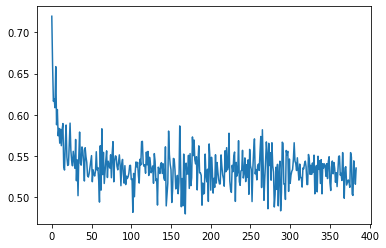

In [ ]:
plt.plot(loss_col)

In [ ]:
torch.save(net, '../data/qual_nets/net1.pkz')

In [ ]:
logr_coefs = {'x_sig': 0.03, 'y_sig': 0.03, 'z_sig': 0.0, 'prob': -2.3}
def log_reg(df, weights={}):
    
    df = df.copy()
    df['score'] = 0
    for k in weights:
        df['score'] += weights[k] * df[k]
    df['score'] = 1/(1 + np.exp(-df['score']))
    return df

In [ ]:
gt_dfs = []
pred_dfs = []

for i in tqdm(range(10)):
    
    with torch.no_grad():

        ret_dict = next(iter(decode_dl))
        x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'], 
        zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
        background = background * micro.get_ch_mult()
        local_rate *= 2

        sim_vars = PointProcessUniform(local_rate[:,0] ,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc, channels=cfg.genm.exp_type.n_channels, n_bits=4, sim_z=True, codebook=torch.tensor(codebook), int_option=cfg.training.int_option).sample(from_code_book=True)
        ch_inp = list(micro.get_single_ch_inputs(*sim_vars[:-1], ycrop=ycrop.flatten(), xcrop=xcrop.flatten()))
        ch_inp[1:4] = add_pos_noise(ch_inp[1:4], [cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_z], cfg.genm.exp_type.n_bits)
        xsim = micro(*ch_inp, add_noise=True)


        noise_vars = PointProcessUniform(local_rate[:,0] * cfg.genm.emitter_noise.rate_fac, int_conc=model.int_dist.int_conc.detach() * cfg.genm.emitter_noise.int_fac, 
                                       int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(), 
                                       sim_iters=5, channels=cfg.genm.exp_type.n_channels, n_bits=1, 
                                       sim_z=cfg.genm.exp_type.pred_z, codebook=None, int_option=cfg.training.int_option).sample(from_code_book=False)     

        noise_inp = micro.get_single_ch_inputs(*noise_vars[:-1], ycrop=ycrop.flatten(), xcrop=xcrop.flatten())
        xsim += micro(*noise_inp, add_noise=True)

        x = micro.noise(xsim, background, const_theta_sim=cfg.genm.exp_type.const_theta_sim).sample()

        colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)
        net_inp = torch.concat([x,colshift_crop], 1)
        
        gt_vars = sim_vars[:-2] 
        gt_df = sample_to_df(*gt_vars, sim_vars[-1], px_size_zyx=[1.,1.,1.])

        res_dict = model(net_inp.cuda())
        res_dict = model.tensor_to_dict(res_dict)
        pred_df = post_proc.get_df(res_dict)
        pred_df['gene'] = targets[pred_df['code_inds']]
#         pred_df = sel_int_ch(pred_df, codebook)
        
        perf, matches, _ = matching(px_to_nm(gt_df), pred_df, tolerance=500, print_res=False)
        
        pred_df.loc[:, 'class'] = 1
        pred_df.loc[pred_df['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0
        
        pred_df = log_reg(pred_df, logr_coefs)
        
        pred_dfs.append(pred_df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.23s/it]


In [ ]:
net.eval()
res_df = cat_emitter_dfs(pred_dfs, decode_dl.batch_size)
inp = input_from_df(res_df, codebook)
inp[:,-22:] *= 0
res_df['net_score'] = cpu(net(inp))

In [ ]:
res_df = sel_int_ch(res_df, codebook)

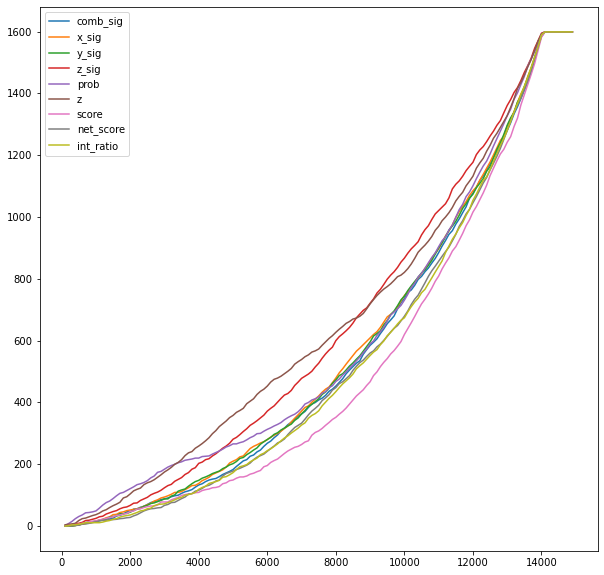

In [ ]:
plt.figure(figsize=(10,10))
for k in ['comb_sig','x_sig','y_sig','z_sig','prob','z','score','net_score','int_ratio']:
    b = False if k in ['tot_int','prob'] else True
    r  = make_roc(res_df, k, n_max=15000, ascending=b)
    plt.plot(r[0],r[1], label=k)
plt.legend()

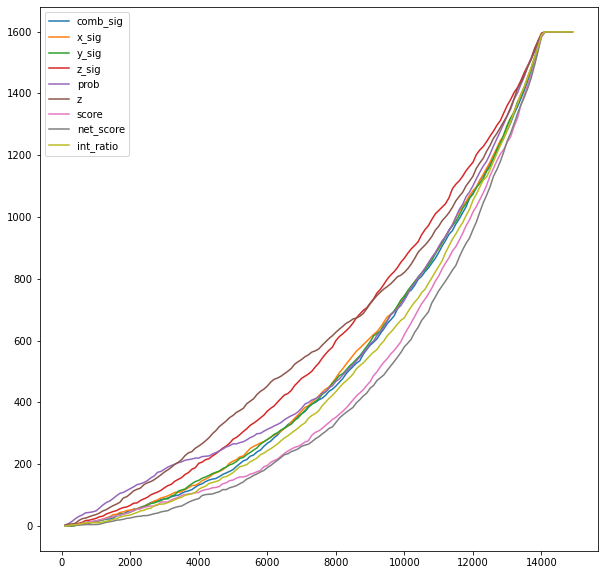

In [ ]:
plt.figure(figsize=(10,10))
for k in ['comb_sig','x_sig','y_sig','z_sig','prob','z','score','net_score','int_ratio']:
    b = False if k in ['tot_int','prob'] else True
    r  = make_roc(res_df, k, n_max=15000, ascending=b)
    plt.plot(r[0],r[1], label=k)
plt.legend()